# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test2'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "bert-base-cased",
}

# Dataset

In this test I will use BERT

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)

In [8]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [10]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [11]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [12]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [15]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [16]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [17]:
for e in dataloader_dev_en:
    ex_in = e
    break

In [18]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'roles_formatted', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position', 'predicate_position_formatted', 'pos_tags'])

In [19]:
print(ex_in['input_ids'][0], ex_in['input_ids'].shape)
print(ex_in['output_mask'][0], ex_in['output_mask'].shape)
print(ex_in['roles_formatted'][0], ex_in['roles_formatted'].shape)

tensor([  101,  1109,  2341, 18029,  1116,  1115,  1103,  1426,  1710,  2653,
         1167,  2209,  1106, 14516,  2316, 17030,  6185,  1103,  1484,  1104,
         1103,  1644,  7742,  6421,   117,  2699,  1105,  4223,  2088,  1164,
         1769,  2266,   119,   102, 18029,  1116,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) torch.Size([32, 80])
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) torch.Size([32, 80])
tensor([-1,  0,  1,  0, -1, 26,  0,  0,  0,  0,  0,  0,  0, 

In [20]:
print(ex_in['predicates'][0], ex_in['predicates'].shape)
print(ex_in['predicate_position_formatted'][0], ex_in['predicate_position_formatted'].shape)

tensor([ -1,   0,   0, 297,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         -1,  -1,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]) torch.Size([32, 80])
tensor(3) torch.Size([32])


In [21]:
torch.set_printoptions(edgeitems=80)
print(ex_in['matrix_subwords'].shape,'\n' , ex_in['matrix_subwords'][0][0:6,:10]) # word_ids[0:6] = [None, 0, 1, 2, 2, 3]
torch.set_printoptions(edgeitems=3)

torch.Size([32, 80, 80]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


# Printing model

In [22]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Training the simple model

In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

First, I'll start by training the simple model, composed of the embedding layer (transformer) to output word embeddings and a simple classifier, which is a linear layer:

In [24]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [26]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

final_model.model.eval()
final_model.model.to(device)

trainer = Trainer_aic_transformer_simple()

with torch.no_grad():
    ex_out_dict = trainer.compute_forward(
        final_model.model, ex_in, device, optimizer = None)

ex_p_f = final_model.model.get_indices(ex_out_dict['predictions'])

print(
    'labels:','\n',
    ex_out_dict['labels'].detach().cpu().tolist()[0],'\n',
    'predictions:','\n',
    ex_p_f.detach().cpu().tolist()[0])

labels: 
 [-1, 0, 1, 0, -1, 26, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] 
 predictions: 
 [1, 0, 0, 0, 16, 16, 0, 1, 16, 0, 0, 0, 16, 25, 9, 25, 25, 1, 0, 0, 1, 3, 3, 0, 9, 9, 9, 16, 3, 16, 0, 3, 1, 5, 0, 25, 5, 1, 0, 0, 1, 1, 27, 17, 14, 14, 25, 25, 27, 1, 1, 17, 1, 27, 27, 27, 27, 1, 9, 17, 14, 14, 14, 25, 27, 14, 27, 9, 17, 14, 27, 27, 1, 27, 27, 27, 17, 17, 25, 17]


In [28]:
history = {}

In [29]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.7,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_fixed_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.290524
# Validation loss => 0.187709 | f1-score: arg_iden = 0.257911 arg_class = 0.196203 #
Epoch   1 => avg_loss: 0.196528
# Validation loss => 0.174495 | f1-score: arg_iden = 0.367053 arg_class = 0.285956 #
Epoch   2 => avg_loss: 0.185083
# Validation loss => 0.166021 | f1-score: arg_iden = 0.318893 arg_class = 0.254750 #
Epoch   3 => avg_loss: 0.179269
# Validation loss => 0.161959 | f1-score: arg_iden = 0.303191 arg_class = 0.241245 #
Epoch   4 => avg_loss: 0.175280
# Validation loss => 0.159196 | f1-score: arg_iden = 0.357363 arg_class = 0.280135 #
Epoch   5 => avg_loss: 0.172670
# Validation loss => 0.157701 | f1-score: arg_iden = 0.303172 arg_class = 0.241913 #
Epoch   6 => avg_loss: 0.170362
# Validation loss => 0.156586 | f1-score: arg_iden = 0.268202 arg_class = 0.213070 #
Epoch   7 => avg_loss: 0.168888
# Validation loss => 0.156656 | f1-score: arg_iden = 0.244776 arg_class = 0.200663 #
Epoch   8 => avg_loss: 0.167532
# Validation loss => 0.152861 | 

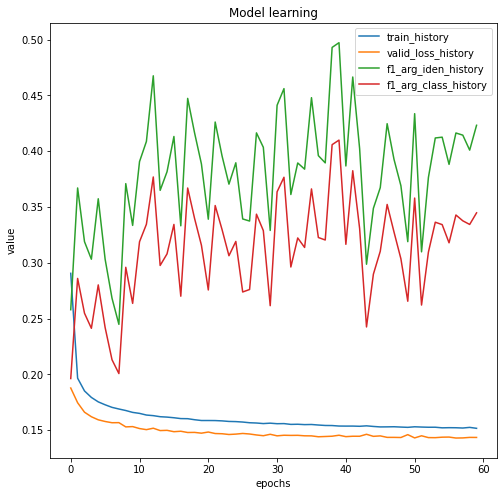

In [30]:
display_history(history)

the model seems to fluctuate a lot during training and improving slowly: dropout, normalization and ReLU layers with more fc layers shoud help.

# Adding fc layers to the model

In [34]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_fc import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
history = {}

In [36]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.7,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_fixed_fc_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.362317
# Validation loss => 0.261418 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   1 => avg_loss: 0.262551
# Validation loss => 0.226852 | f1-score: arg_iden = 0.127379 arg_class = 0.095357 #
Epoch   2 => avg_loss: 0.235387
# Validation loss => 0.206652 | f1-score: arg_iden = 0.239783 arg_class = 0.189655 #
Epoch   3 => avg_loss: 0.220535
# Validation loss => 0.196404 | f1-score: arg_iden = 0.311091 arg_class = 0.242289 #
Epoch   4 => avg_loss: 0.212727
# Validation loss => 0.188999 | f1-score: arg_iden = 0.312156 arg_class = 0.247285 #
Epoch   5 => avg_loss: 0.207060
# Validation loss => 0.184482 | f1-score: arg_iden = 0.339524 arg_class = 0.264364 #
Epoch   6 => avg_loss: 0.202780
# Validation loss => 0.181820 | f1-score: arg_iden = 0.373315 arg_class = 0.294927 #
Epoch   7 => avg_loss: 0.199672
# Validation loss => 0.179383 | f1-score: arg_iden = 0.391121 arg_class = 0.310772 #
Epoch   8 => avg_loss: 0.197393
# Validation loss => 0.176621 | 

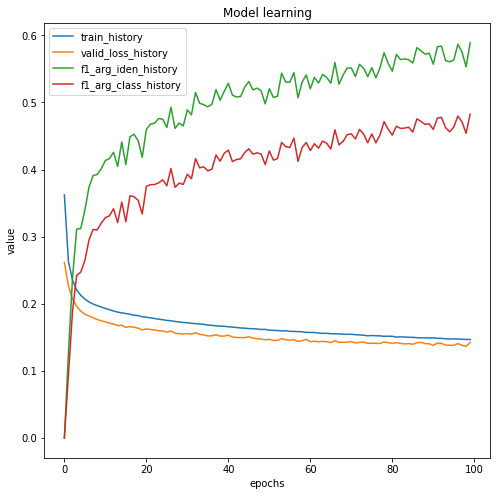

In [37]:
display_history(history)

This model seems to learn a lot better, but it can be done more. Let's add a sequence encoder like a Bi-LSTM layer. This is done by taking inspiration from "Simple BERT Models for Relation Extraction and Semantic Role Labeling" (link: https://arxiv.org/pdf/1904.05255.pdf)

# Adding LSTM

In [38]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_lstm import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
history = {}

In [40]:
from stud.modelsTests.utils.Trainer_aic_transformer_lstm import Trainer_aic_transformer_lstm

trainer = Trainer_aic_transformer_lstm()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=200, device=device,
    save_best=True, 
    min_score=0.7,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_fixed_lstm_fc_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.362767
# Validation loss => 0.272388 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   1 => avg_loss: 0.274726
# Validation loss => 0.239318 | f1-score: arg_iden = 0.152659 arg_class = 0.119726 #
Epoch   2 => avg_loss: 0.249456
# Validation loss => 0.218610 | f1-score: arg_iden = 0.241346 arg_class = 0.187996 #
Epoch   3 => avg_loss: 0.234259
# Validation loss => 0.206174 | f1-score: arg_iden = 0.243495 arg_class = 0.187279 #
Epoch   4 => avg_loss: 0.225563
# Validation loss => 0.199114 | f1-score: arg_iden = 0.281825 arg_class = 0.214695 #
Epoch   5 => avg_loss: 0.219113
# Validation loss => 0.194008 | f1-score: arg_iden = 0.334060 arg_class = 0.261375 #
Epoch   6 => avg_loss: 0.214162
# Validation loss => 0.189469 | f1-score: arg_iden = 0.345906 arg_class = 0.271619 #
Epoch   7 => avg_loss: 0.209502
# Validation loss => 0.185653 | f1-score: arg_iden = 0.354238 arg_class = 0.273482 #
Epoch   8 => avg_loss: 0.206248
# Validation loss => 0.181771 | 

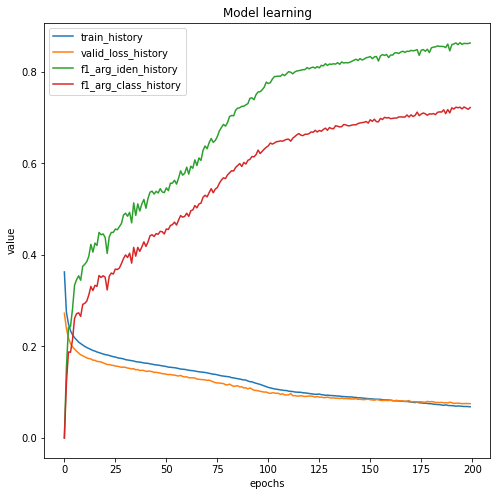

In [41]:
display_history(history)

The model improved

# Fine-tuning BERT

Starting from the same network, we fine-tune BERT

In [42]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_lstm import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
print_summary(final_model.model)

Net_aic_transformer_lstm(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [44]:
history = {}

In [45]:
from stud.modelsTests.utils.Trainer_aic_transformer_lstm import Trainer_aic_transformer_lstm

trainer = Trainer_aic_transformer_lstm()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.7,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_lstm_fc_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.345492
# Validation loss => 0.258847 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   1 => avg_loss: 0.238396
# Validation loss => 0.179611 | f1-score: arg_iden = 0.394290 arg_class = 0.267809 #
Epoch   2 => avg_loss: 0.162150
# Validation loss => 0.123282 | f1-score: arg_iden = 0.838050 arg_class = 0.492694 #
Epoch   3 => avg_loss: 0.130368
# Validation loss => 0.110175 | f1-score: arg_iden = 0.857734 arg_class = 0.540943 #
Epoch   4 => avg_loss: 0.119662
# Validation loss => 0.102438 | f1-score: arg_iden = 0.874307 arg_class = 0.593756 #
Epoch   5 => avg_loss: 0.112567
# Validation loss => 0.100103 | f1-score: arg_iden = 0.881170 arg_class = 0.614053 #
Epoch   6 => avg_loss: 0.106996
# Validation loss => 0.095048 | f1-score: arg_iden = 0.884183 arg_class = 0.624849 #
Epoch   7 => avg_loss: 0.102495
# Validation loss => 0.091202 | f1-score: arg_iden = 0.885256 arg_class = 0.632616 #
Epoch   8 => avg_loss: 0.098743
# Validation loss => 0.088897 | 

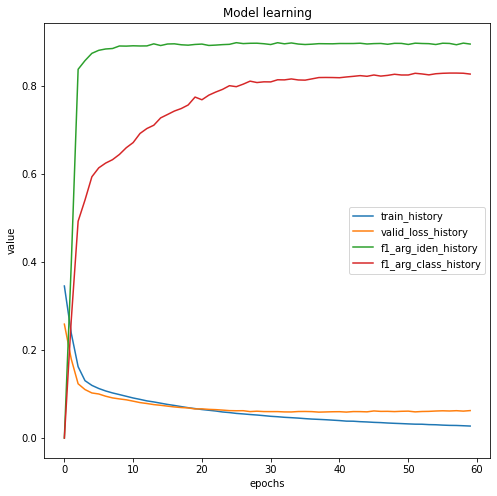

In [46]:
display_history(history)

Fine-tuning BERT improved even more the scores

# Testing

In [48]:
test_input = {
    "dependency_heads": [3,3,0,7,6,7,3,9,7,11,7,15,15,15,11,18,18,15,3],
    "dependency_relations": ["nsubj","advmod","root","mark","det","nsubj","ccomp","amod","obj","mark","advcl","det","amod","amod","obj","case","compound","nmod","punct"],
    "lemmas": ["it","also","recommend","that","the","authority","take","appropriate","measure","to","meet","the","specific","educational","need","of","Roma","child","."],
    "pos_tags": ["PRON","ADV","VERB","SCONJ","DET","NOUN","VERB","ADJ","NOUN","PART","VERB","DET","ADJ","ADJ","NOUN","ADP","PROPN","NOUN","PUNCT"],
    "predicates": ["_","_","PROPOSE","_","_","_","CARRY-OUT-ACTION","_","_","_","SATISFY_FULFILL","_","_","_","_","_","_","_","_"], 
    "words": [
        "It","also","recommends","that","the","authorities","take","appropriate","measures","to",
        "meet","the","specific","educational","needs","of","Roma","children","."]
}

final_test_model = ArgIdenClassModel(language='EN', device=device)
test_out = final_test_model.predict(test_input)
print(test_out)

{'roles': {2: ['agent', '_', '_', 'topic', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 6: ['_', '_', '_', '_', '_', 'agent', '_', '_', 'patient', 'goal', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 10: ['_', '_', '_', '_', '_', 'agent', '_', '_', '_', '_', '_', '_', '_', '_', 'theme', '_', '_', '_', '_']}}


# Finetuning the simple model

Because of how performances changed with fine tuning the last model, I will try to finetune the simple model so to see the difference between these two models.

In [49]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [50]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer=True,
    n_transformer_hidden_states = 1 # !
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [52]:
history = {}

In [53]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.88,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_1sum_weights.pth'),
    saved_history=history
) # best 889-81 before

Epoch   0 => avg_loss: 0.303770
# Validation loss => 0.190889 | f1-score: arg_iden = 0.206826 arg_class = 0.149889 #
Epoch   1 => avg_loss: 0.166554
# Validation loss => 0.120113 | f1-score: arg_iden = 0.842840 arg_class = 0.517234 #
Epoch   2 => avg_loss: 0.125869
# Validation loss => 0.104551 | f1-score: arg_iden = 0.869067 arg_class = 0.572218 #
Epoch   3 => avg_loss: 0.112414
# Validation loss => 0.097898 | f1-score: arg_iden = 0.874462 arg_class = 0.625788 #
Epoch   4 => avg_loss: 0.103862
# Validation loss => 0.090453 | f1-score: arg_iden = 0.881629 arg_class = 0.650938 #
Epoch   5 => avg_loss: 0.096809
# Validation loss => 0.085136 | f1-score: arg_iden = 0.884830 arg_class = 0.672056 #
Epoch   6 => avg_loss: 0.090879
# Validation loss => 0.079594 | f1-score: arg_iden = 0.885203 arg_class = 0.693234 #
Epoch   7 => avg_loss: 0.084881
# Validation loss => 0.074985 | f1-score: arg_iden = 0.889200 arg_class = 0.721449 #
Epoch   8 => avg_loss: 0.079477
# Validation loss => 0.070981 | 

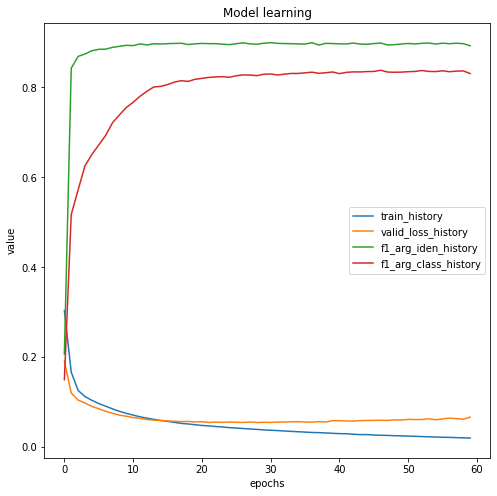

In [54]:
display_history(history)

# Finetuning the simple model (4 layers sum)

In this case, the last four layers of the transformer are summed!

In [55]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [56]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer=True,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [58]:
history = {}

In [59]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_weights.pth'),
    saved_history=history
) # best 889-813 brfore

Epoch   0 => avg_loss: 0.289974
# Validation loss => 0.149230 | f1-score: arg_iden = 0.523369 arg_class = 0.384626 #
Epoch   1 => avg_loss: 0.137247
# Validation loss => 0.096926 | f1-score: arg_iden = 0.845865 arg_class = 0.628619 #
Epoch   2 => avg_loss: 0.106269
# Validation loss => 0.085562 | f1-score: arg_iden = 0.863111 arg_class = 0.677513 #
Epoch   3 => avg_loss: 0.092582
# Validation loss => 0.076692 | f1-score: arg_iden = 0.872570 arg_class = 0.709781 #
Epoch   4 => avg_loss: 0.082640
# Validation loss => 0.070704 | f1-score: arg_iden = 0.881172 arg_class = 0.745283 #
Epoch   5 => avg_loss: 0.075816
# Validation loss => 0.066566 | f1-score: arg_iden = 0.883340 arg_class = 0.761886 #
Epoch   6 => avg_loss: 0.070471
# Validation loss => 0.063250 | f1-score: arg_iden = 0.883754 arg_class = 0.776650 #
Epoch   7 => avg_loss: 0.065628
# Validation loss => 0.063248 | f1-score: arg_iden = 0.884657 arg_class = 0.781388 #
Epoch   8 => avg_loss: 0.061729
# Validation loss => 0.060078 | 

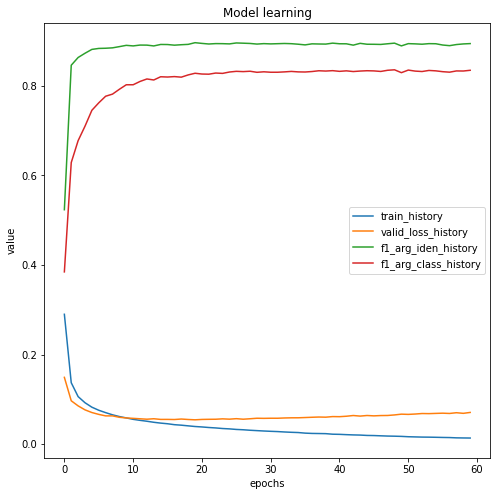

In [60]:
display_history(history)

The model seems to do a better job than the one with lstm and fc layers. This could really mean that "attention is all you need" :)

In [108]:
from stud.modelsTests.utils.print_infos import *

In [109]:
val_labels, val_predictions, valid_loss = trainer.compute_arg_iden_class_validation_predictions(final_model.model, dataloader_dev_en, device)

In [110]:
val_labels_formatted = [ role_val for roles in val_labels.values() for role_list in roles['roles'].values() for role_val in role_list ]
val_predictions_formatted = [ role_val for roles in val_predictions.values() for role_list in roles['roles'].values() for role_val in role_list ]

In [111]:
val_labels_iden_formatted = [1 if role_val > 0 else 0 for roles in val_labels.values() for role_list in roles['roles'].values() for role_val in role_list ]
val_predictions_iden_formatted = [1 if role_val > 0 else 0 for roles in val_predictions.values() for role_list in roles['roles'].values() for role_val in role_list ]

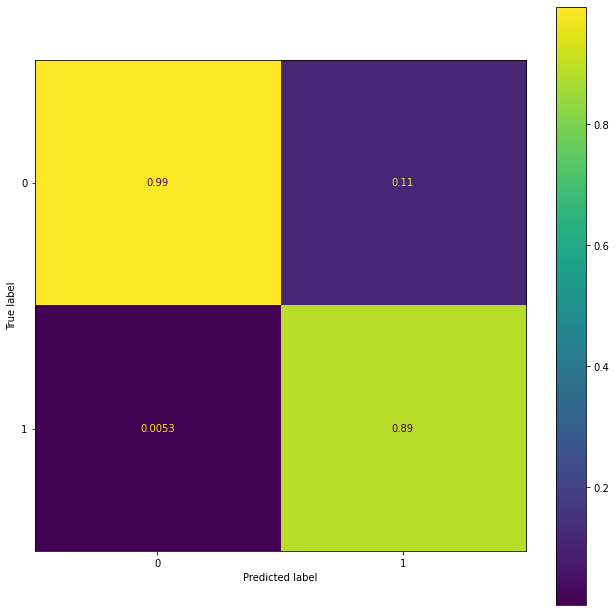

In [117]:
plot_confusion_matrix(val_labels_iden_formatted, val_predictions_iden_formatted, display_labels=None)

In [118]:
print_classification_report(val_labels_iden_formatted, val_predictions_iden_formatted, target_names=None)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     95633
           1       0.89      0.90      0.89      5013

    accuracy                           0.99    100646
   macro avg       0.94      0.95      0.94    100646
weighted avg       0.99      0.99      0.99    100646



In [119]:
len(dataset_train_en.labels['id_to_roles'])

28

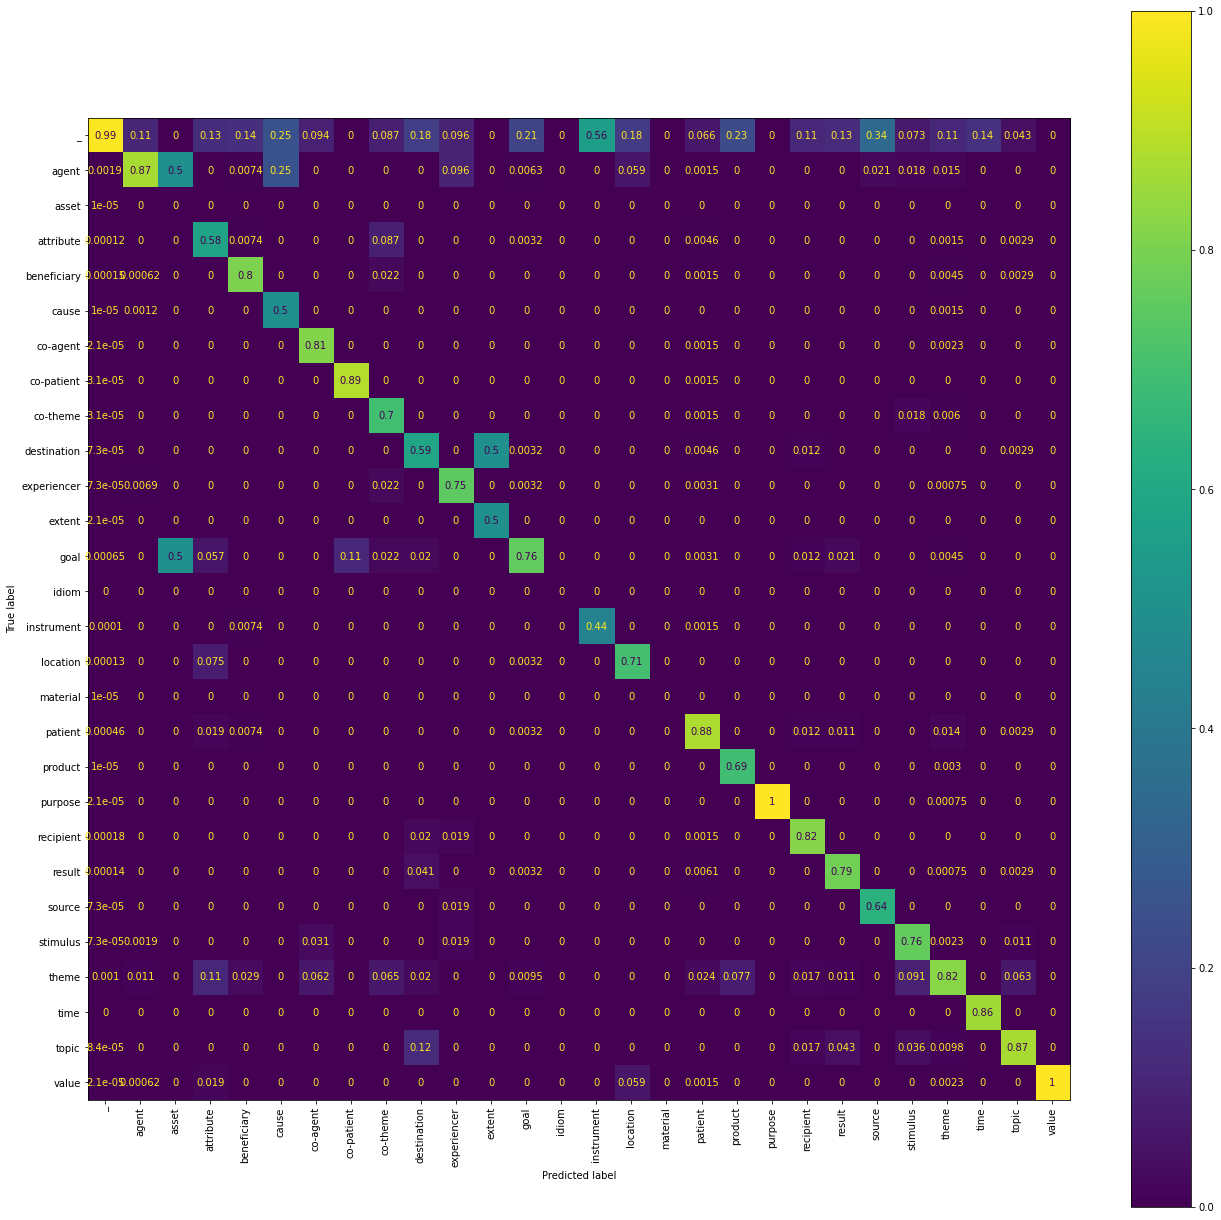

In [137]:
plot_confusion_matrix(val_labels_formatted, val_predictions_formatted, display_labels=dataset_train_en.labels['id_to_roles'])